In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def weight_variable(name, shape):
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=tf.initializers.glorot_uniform)

def bias_variable(name, shape):
    return tf.get_variable(name=name, dtype=tf.float32,
                          initializer=tf.constant(0., shape=shape))

## Time-Series Forcasting

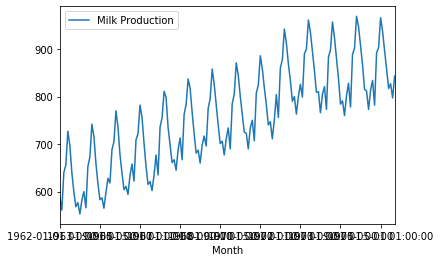

In [3]:
"""
Credit to https://www.udemy.com/course/complete-guide-to-tensorflow-for-deep-learning-with-python
"""

sample_data = pd.read_csv('data/monthly-milk-production.csv', index_col='Month')
sample_data.plot()
sample_data.head()

seq = sample_data['Milk Production'].values
test_seq = seq[-12:]
train_seq = seq[:-12]

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_seq = scaler.fit_transform(train_seq.reshape(-1, 1))
test_seq = scaler.transform(test_seq.reshape(-1, 1))

In [5]:
n_in = 1
n_out = 1
batch_size = 1
time_step_size = 12
n_hid = 100

learning_rate = 0.001
epochs = 10000

In [6]:
def next_batch(seq, time_step_size, batch_size):
    y_batch = []
    for i in range(batch_size):
        start_index = np.random.randint(0, high=len(seq) - time_step_size)
        y_batch.append(seq[start_index:start_index + time_step_size + 1].reshape(
            1, time_step_size + 1, -1))
        
    y_batch = np.concatenate(y_batch, axis=0)
    
    return y_batch[:,:-1, :], y_batch[:, 1:, :]

In [7]:
_x, _y = next_batch(train_seq, time_step_size, batch_size)
print(_x.shape) # (batch_size, time_step_size,embedding_size, )

(1, 12, 1)


In [8]:
"""
Model Definition
"""
x = tf.placeholder(tf.float32, [None, time_step_size, n_in])
y = tf.placeholder(tf.float32, [None, time_step_size, n_out])

cell = tf.nn.rnn_cell.BasicLSTMCell(n_hid, activation=tf.nn.relu)
output, memory = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

W = weight_variable('W', [n_hid, n_out])
b = bias_variable('b', [n_out])

y_pred = tf.nn.relu(tf.matmul(output, W) + b)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
loss = tf.reduce_mean(tf.square(y - y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [10]:
writer = tf.summary.FileWriter('logs/', tf.get_default_graph())
tf.summary.scalar('training_loss', loss)
summaries = tf.summary.merge_all()

In [11]:
predicted_seq = []
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(epochs):
        x_batch, y_batch = next_batch(train_seq, time_step_size, batch_size)
        
        _, loss_step, _summary = sess.run([train, loss, summaries], 
                                          feed_dict={x: x_batch, y: y_batch})
        writer.add_summary(_summary, global_step=i)
        if i % 100 == 0:
            print(f'Epoch {i}:\tTraining Loss - {loss_step:.04f}')
        
    
    seq = list(train_seq[-12:, :].squeeze())
    
    for j in range(12):
        x_batch = np.array(seq[-12:]).reshape(1, time_step_size, -1)
        pred = sess.run(y_pred, feed_dict={x:x_batch})
        seq.append(pred[0,-1, 0])
        

Epoch 0:	Training Loss - 0.1064
Epoch 100:	Training Loss - 0.0178
Epoch 200:	Training Loss - 0.0229
Epoch 300:	Training Loss - 0.0151
Epoch 400:	Training Loss - 0.0134
Epoch 500:	Training Loss - 0.0152
Epoch 600:	Training Loss - 0.0078
Epoch 700:	Training Loss - 0.0120
Epoch 800:	Training Loss - 0.0086
Epoch 900:	Training Loss - 0.0140
Epoch 1000:	Training Loss - 0.0090
Epoch 1100:	Training Loss - 0.0085
Epoch 1200:	Training Loss - 0.0042
Epoch 1300:	Training Loss - 0.0089
Epoch 1400:	Training Loss - 0.0064
Epoch 1500:	Training Loss - 0.0085
Epoch 1600:	Training Loss - 0.0083
Epoch 1700:	Training Loss - 0.0090
Epoch 1800:	Training Loss - 0.0057
Epoch 1900:	Training Loss - 0.0089
Epoch 2000:	Training Loss - 0.0062
Epoch 2100:	Training Loss - 0.0047
Epoch 2200:	Training Loss - 0.0092
Epoch 2300:	Training Loss - 0.0053
Epoch 2400:	Training Loss - 0.0122
Epoch 2500:	Training Loss - 0.0048
Epoch 2600:	Training Loss - 0.0073
Epoch 2700:	Training Loss - 0.0062
Epoch 2800:	Training Loss - 0.00

In [12]:
pred = seq[-12:]
pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
pred = pred.squeeze().tolist()


/home/joanna/anaconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


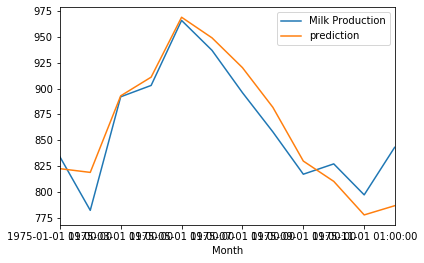

In [13]:
test_df = sample_data.tail(12)
test_df['prediction'] = pred

test_df.plot()


## Manual Implementation of single cells 
#### Simple RNN
#### GRU
#### LSTM

In [ ]:
"""
Implementation of single cell for simple RNN, LSTM, and GRU
"""

class SingleRNNCellExamples:
    def __init__(self, input_vocab_size, embedding_dim, n_hid):
        #self.embedding = tf.Variable(tf.random_uniform([input_vocab_size, embedding_dim]))
        self.n_hid = n_hid
        
        # SimpleRNN
        self.rnn_W = weight_variable('rnn_W', [embedding_dim + n_hid, n_hid])
        self.rnn_b = bias_variable('rnn_b', [n_hid])
        
        # GRU
        self.gru_W_h = weight_variable('gru_W_h', [embedding_dim + n_hid, n_hid])
        self.gru_b_h = bias_variable('gru_b_h', [n_hid])
        
        self.gru_W_r = weight_variable('gru_W_r', [embedding_dim + n_hid, n_hid])
        self.gru_b_r = bias_variable('gru_b_r', [n_hid])
        
        self.gru_W_u = weight_variable('gru_W_u', [embedding_dim + n_hid, n_hid])
        self.gru_b_u = bias_variable('gru_b_u', [n_hid])
        
        # LSTM
        self.lstm_W_o = weight_variable('lstm_W_o', [embedding_dim + n_hid, n_hid])
        self.lstm_b_o = bias_variable('lstm_b_o', [n_hid])
        
        self.lstm_W_u = weight_variable('lstm_W_u', [embedding_dim + n_hid, n_hid])
        self.lstm_b_u = bias_variable('lstm_b_u', [n_hid])    
 
        self.lstm_W_f = weight_variable('lstm_W_f', [embedding_dim + n_hid, n_hid])
        self.lstm_b_f = bias_variable('lstm_b_f', [n_hid])    
        
        self.lstm_W_h = weight_variable('lstm_W_h', [embedding_dim + n_hid, n_hid])
        self.lstm_b_h = bias_variable('lstm_b_h', [n_hid])
        
    def _rnn(self, x, hid, activation=tf.nn.tanh):
        _input = tf.concat([x, hid], -1)
        return activation(tf.matmul(_input, self.rnn_W) + self.rnn_b)
    
    def _gru(self, x, hid):
        _input = tf.concat([x, hid], -1)
        relevance_gate = tf.nn.sigmoid(tf.matmul(_input, self.gru_W_r) + self.gru_b_r)
        update_gate = tf.nn.sigmoid(tf.matmul(_input, self.gru_W_u) + self.gru_b_u)
        
        scaled_input = tf.concat([x, tf.multiply(relevance_gate, hid)], -1)
        candidate_hid = tf.nn.sigmoid(tf.matmul(scaled_input, self.gru_W_h) + self.gru_b_h) 
        
        return update_gate * candidate_hidden + (tf.ones_like(update_gate) - update_gate) * hid
    
    def _lstm(self, x, hid):
        _input = tf.concat([x, hid], -1)
        candidate_hid = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_h) + self.lstm_b_h)
        
        update_gate = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_u) + self.lstm_b_u)
        forget_gate = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_f) + self.lstm_b_f)
        output_gate = tf.nn.sigmoid(tf.matmul(_input, self.lstm_W_o) + self.lstm_b_o)
        
        hid = update_gate * candidate_hid + forget_gate * hid
        return output_gate * tf.nn.tanh(hid)